In [6]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

from src.QAOA import QAOA
from src.Pennylane_QAOA import Pennylane_QAOA
from src.Cirq_QAOA import Cirq_QAOA
from src.Qsimcirq_QAOA import Qsimcirq_QAOA
from src.Qulacs_QAOA import Qulacs_QAOA
from src.Spynoza_QAOA import Spynoza_QAOA

from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       qubo_limits, 
                       check_qubo)

In [9]:
N_min, N_max = 6, 17

cirq_res =      {N: [] for N in range(N_min, N_max + 1)}
pennylane_res = {N: [] for N in range(N_min, N_max + 1)}
qiskit_res =    {N: [] for N in range(N_min, N_max + 1)}
qsim_res =      {N: [] for N in range(N_min, N_max + 1)}
spynoza_res =   {N: [] for N in range(N_min, N_max + 1)}
qulacs_res =   {N: [] for N in range(N_min, N_max + 1)}

N_seeds = 7
seed = 100
 # Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]
for N in tqdm(range(N_min, N_max+1)):
    k = N // 2
    init_strat = np.array([1 if i%2 == 1 else 0 for i in range(N)])
    my_indices = [(i, i+1) for i in range(N-1)]
    n_layers = 4
    alpha = 0.5
    max_iter = 10
    for repetition in range(N_seeds):
         # Defining topology
        my_chain = Chain(N_qubits=N)
        my_chain.set_initialization_strategy(strategy=init_strat)
        # Deciding between grid and 1d chain topology
        my_topology = my_chain
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
        # Retrieving C_min, C_max and corresponding states for original portfolio problem
        constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                    k=k,
                                                                    mu=expected_returns,
                                                                    sigma=covariances,
                                                                    alpha=alpha)
        portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
        portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
        # Generating QUBO corresponding to current problem instance
        Q, offset = get_qubo(mu=expected_returns,
                             sigma=covariances, 
                             alpha=alpha,
                             lmbda=lmbda+1e-8, # Adding small constant purposely
                             k=k)
        QUBO_limits = qubo_limits(Q=Q,offset=offset)
        qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
        qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
        check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
        qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
        
        if not portfolio_subspace_min_state_str == qubo_min_state_str:
            raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
            raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
        
        if not qubo_max_cost >= portfolio_subspace_max_cost:
            raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
         
        qiskit_ansatz = QAOA(N_qubits=N,
                     layers=n_layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     constraining_mixer=False,
                     Topology=my_topology)
         
        pennylane_ansatz = Pennylane_QAOA(N_qubits=N,
                                          layers=n_layers,
                                          QUBO_matrix=Q,
                                          QUBO_offset=offset)
        qsim_ansatz = Qsimcirq_QAOA(N_qubits=N,
                                    layers=n_layers,
                                    QUBO_matrix=Q,
                                    QUBO_offset=offset)
        cirq_ansatz = Cirq_QAOA(N_qubits=N,
                                          layers=n_layers,
                                          QUBO_matrix=Q,
                                          QUBO_offset=offset)
        
        spynoza_ansatz = Spynoza_QAOA(N_qubits=N,
                                          layers=n_layers,
                                          QUBO_matrix=Q,
                                          QUBO_offset=offset)
         
        qulacs_ansatz = Qulacs_QAOA(N_qubits=N,
                                    layers=n_layers,
                                    QUBO_matrix=Q,
                                    QUBO_offset=offset)
         
        
        # Generating initial guess for rotation angles
        np.random.seed(seed)
        theta_min, theta_max = -2*np.pi, 2*np.pi
        N_angles = 2 * n_layers
        theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
        
        
        qiskit_start_time = time()
        qiskit_sim = sc.optimize.minimize(fun=qiskit_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qiskit_stop_time = time()
        if qiskit_sim['nfev'] > 0:
            time_pr_iter = (qiskit_stop_time-qiskit_start_time) / qiskit_sim['nfev']
            qiskit_res[N].append(time_pr_iter)
        
        
        pennylane_start_time = time()
        pennylane_sim = sc.optimize.minimize(fun=pennylane_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        pennylane_stop_time = time()
        if pennylane_sim['nfev'] > 0:
            time_pr_iter = (pennylane_stop_time-pennylane_start_time) / pennylane_sim['nfev']
            pennylane_res[N].append(time_pr_iter)
            
        
        cirq_start_time = time()
        cirq_sim = sc.optimize.minimize(fun=cirq_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        cirq_stop_time = time()
        if cirq_sim['nfev'] > 0:
            time_pr_iter = (cirq_stop_time-cirq_start_time) / cirq_sim['nfev']
            cirq_res[N].append(time_pr_iter)
        
        
        qsim_start_time = time()
        qsim_sim = sc.optimize.minimize(fun=qsim_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qsim_stop_time = time()
        if qsim_sim['nfev'] > 0:
            time_pr_iter = (qsim_stop_time-qsim_start_time) / qsim_sim['nfev']
            qsim_res[N].append(time_pr_iter)
             
        spynoza_start_time = time()
        spynoza_sim = sc.optimize.minimize(fun=spynoza_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        spynoza_stop_time = time()
        if spynoza_sim['nfev'] > 0:
            time_pr_iter = (spynoza_stop_time-spynoza_start_time) / spynoza_sim['nfev']
            spynoza_res[N].append(time_pr_iter)
             
        qulacs_start_time = time()
        qulacs_sim = sc.optimize.minimize(fun=qulacs_ansatz.get_cost, 
                                  x0=theta_i,
                                  method=optimizer_method,
                                  options={'disp': False, 
                                           'maxiter': max_iter})
        qulacs_stop_time = time()
        if qulacs_sim['nfev'] > 0:
            time_pr_iter = (qulacs_stop_time-qulacs_start_time) / qulacs_sim['nfev']
            qulacs_res[N].append(time_pr_iter)
            
        seed += 1

100%|██████████| 12/12 [19:38<00:00, 98.19s/it] 


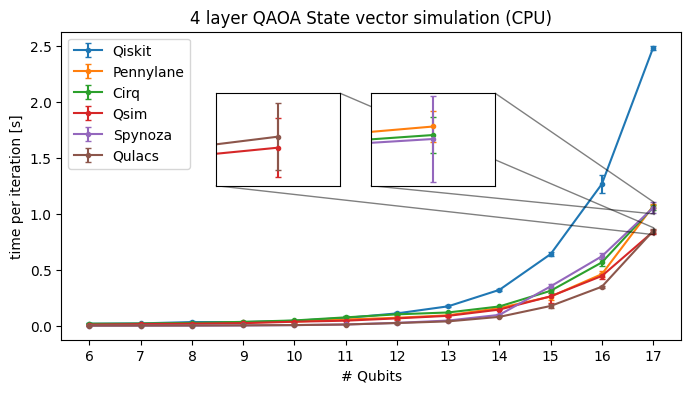

In [38]:
qiskit_avgs = np.array([[np.mean(qiskit_res[key]), np.std(qiskit_res[key])] for key in qiskit_res.keys()])
pennylane_avgs = np.array([[np.mean(pennylane_res[key]), np.std(pennylane_res[key])] for key in pennylane_res.keys()])
cirq_avgs = np.array([[np.mean(cirq_res[key]), np.std(cirq_res[key])] for key in cirq_res.keys()])
qsim_avgs = np.array([[np.mean(qsim_res[key]), np.std(qsim_res[key])] for key in qsim_res.keys()])
spynoza_avgs = np.array([[np.mean(spynoza_res[key]), np.std(spynoza_res[key])] for key in spynoza_res.keys()])
qulacs_avgs = np.array([[np.mean(qulacs_res[key]), np.std(qulacs_res[key])] for key in qulacs_res.keys()])

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_title('4 layer QAOA State vector simulation (CPU)')

ax.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
ax.errorbar(N_vals, pennylane_avgs[:,0], yerr=pennylane_avgs[:,1], fmt='.-', capsize=2, label='Pennylane', color='tab:orange')
ax.errorbar(N_vals, cirq_avgs[:,0], yerr=cirq_avgs[:,1], fmt='.-', capsize=2, label='Cirq', color='tab:green')
ax.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
ax.errorbar(N_vals, spynoza_avgs[:,0], yerr=spynoza_avgs[:,1], fmt='.-', capsize=2, label='Spynoza', color='tab:purple')
ax.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:brown')

ax.set_ylabel('time per iteration [s]')
ax.set_xlabel('# Qubits')
ax.set_xticks(N_vals)
################## miniplot ##################
# inset axes....
axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.5, 0.5, 0.2, 0.3
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(N_vals, pennylane_avgs[:,0], yerr=pennylane_avgs[:,1], fmt='.-', capsize=2, label='Pennylane', color='tab:orange')
axins.errorbar(N_vals, cirq_avgs[:,0], yerr=cirq_avgs[:,1], fmt='.-', capsize=2, label='Cirq', color='tab:green')
axins.errorbar(N_vals, spynoza_avgs[:,0], yerr=spynoza_avgs[:,1], fmt='.-', capsize=2, label='Spynoza', color='tab:purple')
axins.set_xticks([])
axins.set_yticks([])
# sub region of the original image
x1, x2, y1, y2 = 16.99, 17.01, 1., 1.105
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis='both', which='major', labelsize=10)
ax.indicate_inset_zoom(axins, edgecolor="black")

axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.25, 0.5, 0.2, 0.3
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])
axins.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='qsim', color='tab:red')
axins.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:brown')

axins.set_xticks([])
axins.set_yticks([])
# sub region of the original image
x1, x2, y1, y2 = 16.99, 17.01, 0.815, 0.875
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(axis='both', which='major', labelsize=10)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend()
plt.savefig('simulator_comparison_2.png', dpi=400)